## RegNet Training

In [155]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import regnet_y_800mf, RegNet_Y_800MF_Weights
from torchvision import transforms
from IPython.display import Audio
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import torch.nn.functional as F
from tqdm import tqdm
import timm
import torchaudio

import copy
import random
import glob
import os
import time
import sys

In [156]:
RANDOM_SEED = 21

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [157]:
## REUSE IN INFERENCE NOTEBOOK

custom_dataset_path = '/kaggle/input/birdclef2023-inference'
if os.path.exists(os.path.join(custom_dataset_path, 'utils.py')):
    sys.path.append(custom_dataset_path)
else:
    sys.path.append('..')
import utils

IS_IN_KAGGLE_ENV = utils.get_is_in_kaggle_env()

DATA_PATH = '/kaggle/input/birdclef-2023' if IS_IN_KAGGLE_ENV else '../data'
JOBLIB_PATH = custom_dataset_path if IS_IN_KAGGLE_ENV else './'

DEVICE = 'cpu' if IS_IN_KAGGLE_ENV else utils.determine_device()

AUDIO_LENGTH_S = 5
SAMPLE_RATE = 32_000

We are running code on Localhost
We are using device: mps


In [158]:
if not IS_IN_KAGGLE_ENV and not os.path.exists(DATA_PATH):
    print("Downloading data ...")
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

DF_METADATA_CSV = pd.read_csv(f"{DATA_PATH}/train_metadata.csv")

AUDIO_DATA_DIR = f"{DATA_PATH}/train_audio/"

In [159]:
# Rows with 1 sample: copy twice, rows with 2 samples: copy once
# This is to ensure that stratified sampling for train/valid/test splits works correctly
def ensure_min_two_samples(DF_METADATA_CSV):
    class_counts = DF_METADATA_CSV["primary_label"].value_counts()

    one_sample_rows = DF_METADATA_CSV[DF_METADATA_CSV["primary_label"].isin(class_counts[class_counts == 1].index)]
    print(f"Number of rows with 1 sample: {len(one_sample_rows)}")
    if len(one_sample_rows) > 0:
        DF_METADATA_CSV = pd.concat([DF_METADATA_CSV, one_sample_rows, one_sample_rows], ignore_index=True)
    
    two_sample_rows = DF_METADATA_CSV[DF_METADATA_CSV["primary_label"].isin(class_counts[class_counts == 2].index)]
    print(f"Number of rows with 2 samples: {len(two_sample_rows)}")
    if len(two_sample_rows) > 0:
        DF_METADATA_CSV = pd.concat([DF_METADATA_CSV, two_sample_rows], ignore_index=True)

    return DF_METADATA_CSV

DF_METADATA_CSV = ensure_min_two_samples(DF_METADATA_CSV)

# Run again to verify
DF_METADATA_CSV = ensure_min_two_samples(DF_METADATA_CSV)

Number of rows with 1 sample: 7
Number of rows with 2 samples: 6
Number of rows with 1 sample: 0
Number of rows with 2 samples: 0


In [160]:
## REUSE IN INFERENCE NOTEBOOK

# class BirdMelspecClf(nn.Module):
#     def __init__(self, out_features, pretrained):
#         super().__init__()

#         self.cnn = timm.create_model('regnety_080', pretrained=pretrained)
#         for name, param in self.cnn.named_parameters():
#             if param.requires_grad:
#                 print(name)

#         # Replace original stem for black and white images
#         self.cnn.stem.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

#         # Replace original classifier for our task
#         self.cnn.head.fc = nn.Sequential(
#             nn.Linear(self.cnn.head.fc.in_features, 1024),
#             nn.BatchNorm1d(1024),
#             nn.PReLU(),

#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.PReLU(),
            
#             nn.Linear(512, out_features),
#         )

#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         logits = self.cnn(x)
#         probas = self.softmax(logits)

#         return logits, probas


class BirdMelspecClf(nn.Module):
    def __init__(self, out_features, pretrained):
        super().__init__()
        
        # https://pytorch.org/vision/stable/models.html

        self.regnet = regnet_y_800mf(weights=RegNet_Y_800MF_Weights.DEFAULT) if pretrained else regnet_y_800mf()

        """
        Replace the stem to take 1 channel instead of 3. The original stem:
        RegnetCNN(
        (regnet): RegNet(
            (stem): SimpleStemIN(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
        )"""
        self.regnet.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
        # Fine-tune the regnet classifier
        self.regnet.fc = nn.Sequential(
            nn.Linear(self.regnet.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            
            nn.Linear(256, out_features),
        )

        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        logits = self.regnet(x)
        probas = self.softmax(logits)

        return logits, probas


def get_model(out_features, device, pretrained=False, load_state_dict=True):
    model = BirdMelspecClf(out_features=out_features, pretrained=pretrained)
    print(f"Loaded model {model.__class__.__name__} with {sum(p.numel() for p in model.parameters())} parameters, pretained={pretrained}")
    model.to(device)
    if load_state_dict:
        model_path = os.path.join(JOBLIB_PATH, 'best_model.pt')
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded model weights from {model_path}")
    model.to(device)
    return model

In [161]:
UNIQUE_CLASSES = DF_METADATA_CSV.primary_label.unique()
N_CLASSES = len(UNIQUE_CLASSES)
print(f"Number of classes: {N_CLASSES}")

Number of classes: 264


In [162]:
train_classes_paths = glob.glob(f"{DATA_PATH}/train_audio/*")
len(train_classes_paths), train_classes_paths[0]

(264, '../data/train_audio/ruegls1')

In [163]:
print(f"Total samples in dataset: {len(DF_METADATA_CSV)}")

Total samples in dataset: 16961


In [164]:
class_with_fewest_samples = DF_METADATA_CSV.primary_label.value_counts(sort=True).index[-1]
print(f"Class with fewest samples: {class_with_fewest_samples}: {DF_METADATA_CSV.primary_label.value_counts().min()} samples")

Class with fewest samples: crefra2: 3 samples


In [165]:
## REUSE IN INFERENCE NOTEBOOK

def resample(audio, current_sample_rate, desired_sample_rate=SAMPLE_RATE):
    resampler = torchaudio.transforms.Resample(orig_freq=current_sample_rate, new_freq=desired_sample_rate)
    resampled_audio = resampler(audio)
    return resampled_audio

def load_audio(audio_path, sample_rate=SAMPLE_RATE):
    audio, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        audio = resample(audio, sr, sample_rate)
    return audio

def get_melspec_transform(sample_rate=SAMPLE_RATE, n_fft=1024, win_length=1024, hop_length=512, n_mels=128, f_min=0, f_max=SAMPLE_RATE // 2, normalized=True):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=f_min,
        f_max=f_max,
        normalized=normalized,
    )

def get_melspec_db_transform(stype='power', top_db=80):
    return torchaudio.transforms.AmplitudeToDB(
        stype=stype,
        top_db=top_db
    )

def normalize_melspec(spectrogram):
    min_val = torch.min(spectrogram)
    max_val = torch.max(spectrogram)
    if max_val - min_val == 0:
        return spectrogram
    else:
        return (spectrogram - min_val) / (max_val - min_val)

In [166]:
class BirdClef23Dataset(Dataset):
    def __init__(self, df, audio_data_dir, label_encoder, n_mels, device, pad_method='wrap', melspecs_per_audio=5):
        self.df = df
        self.audio_data_dir = audio_data_dir
        self.label_encoder = label_encoder
        self.device = device
        self.pad_method = pad_method
        self.melspecs_per_audio = melspecs_per_audio
        self.melspec_transform = get_melspec_transform(n_mels=n_mels)
        self.melspec_db_transform = get_melspec_db_transform()

    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_data_dir, self.df.iloc[index, 11])
        audio = load_audio(audio_path, SAMPLE_RATE)

        # Increase audio length if below {AUDIO_LENGTH_S} by padding
        if audio.shape[1] < AUDIO_LENGTH_S * SAMPLE_RATE:
            padding_needed = AUDIO_LENGTH_S * SAMPLE_RATE - audio.shape[1]

            if self.pad_method in ['wrap', 'wrap_mirror']:
                audio = F.pad(audio, (0, padding_needed), mode='replicate')

            elif self.pad_method == 'zeros':
                audio = F.pad(audio, (0, padding_needed), mode='constant', value=0)

        # Create a mirrored version of the audio array and concatenate it
        if self.pad_method == 'wrap_mirror':
            mirrored_audio_torch = audio.flip(dims=(1,))
            audio = torch.cat((audio, mirrored_audio_torch), dim=1)

        # Taking random melspecs of length AUDIO_LENGTH_S * SAMPLE_RATE
        melspecs = [] # cropped audio of length AUDIO_LENGTH_S * SAMPLE_RATE as mel spectrograms
        if audio.shape[1] > AUDIO_LENGTH_S * SAMPLE_RATE:
            # The audio is longer than the desired length, so we take random crops
            for _ in range(self.melspecs_per_audio):
                max_start_idx = audio.shape[1] - (SAMPLE_RATE * AUDIO_LENGTH_S)
                start_idx = torch.randint(0, max_start_idx, (1,)).item()
                crop = audio[:, start_idx:start_idx + (SAMPLE_RATE * AUDIO_LENGTH_S)]
                normalized_db_melspec = normalize_melspec(self.melspec_db_transform(self.melspec_transform(crop)))
                melspecs.append(normalized_db_melspec)
        elif audio.shape[1] == AUDIO_LENGTH_S * SAMPLE_RATE:
            # The audio is exactly the desired length, so we don't need to crop, and add it melspecs_per_audio times
            normalized_db_melspec = normalize_melspec(self.melspec_db_transform(self.melspec_transform(audio)))
            melspecs = [normalized_db_melspec] * self.melspecs_per_audio
        else:
            # The audio is shorter than the desired length, which means the padding above failed
            raise Exception(f"Audio is shorter than {AUDIO_LENGTH_S} seconds: {audio.shape[1] / SAMPLE_RATE} seconds")
        
        primary_label_raw = self.df.iloc[index, 0]
        primary_label = self.label_encoder.transform([primary_label_raw])[0]

        return melspecs, primary_label

    def __len__(self):
        return len(self.df)


def collate_fn(batch):
    # Flatten the list of melspectrograms. This increases the batch size to batch_size * melspecs_per_audio
    melspecs, primary_labels = zip(*batch)
    melspecs = [item for sublist in melspecs for item in sublist] 
    repeat_factor = len(melspecs) // len(primary_labels)
    primary_labels = list(primary_labels) * repeat_factor
    return torch.stack(melspecs), torch.tensor(primary_labels, dtype=torch.long)


def get_data_loader(dataset, batch_size=32, data_percentage=None, shuffle=False, pin_memory=False):
    if data_percentage is not None:
        data_len = int(len(dataset) * data_percentage)
        dataset, _ = random_split(dataset, [data_len, len(dataset) - data_len])

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, collate_fn=collate_fn)

    return data_loader


def split_df(df, primary_label='primary_label', percentages=[60, 20, 20]):
    """
    - Percentages: [train, valid, test]
    - Splits a dataframe into three dataframes (train, valid, test), stratified by primary_label
    - Also returns the class weights (based on the training set)
    """
    print(f"Splitting dataframe into train {percentages[0]}%, valid {percentages[1]}%, test {percentages[2]}%, stratified by {primary_label}")
    
    train_perc, valid_perc, test_perc = [perc / 100 for perc in percentages]
    train_valid_split = round(train_perc / (train_perc + valid_perc), 2)
    
    temp_df, test_df = train_test_split(df, test_size=test_perc, stratify=df[primary_label], random_state=RANDOM_SEED)
    
    train_df, valid_df = train_test_split(temp_df, test_size=1-train_valid_split, stratify=temp_df[primary_label], random_state=RANDOM_SEED)

    classes = np.unique(train_df[primary_label])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df[primary_label])

    return train_df, valid_df, test_df, class_weights


def train(model, train_loader, valid_loader, loss_func, optimizer, num_epochs, validate_on_train, scheduler, device):
    minibatch_loss, train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst, best_valid_acc = [], [], [], [], [], 0.0
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        
        for melspec, primary_label in tqdm(train_loader, total=len(train_loader), desc="Training batches"):
            features = melspec.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)

            loss = loss_func(logits, targets)

            optimizer.zero_grad()
            
            loss.backward()

            minibatch_loss.append(loss.item())
            
            optimizer.step()
            
        train_acc, train_loss = validate(model, device, train_loader, loss_func) if validate_on_train else (torch.tensor(0.0), torch.tensor(0.0))
        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss)

        valid_acc, valid_loss = validate(model, device, valid_loader, loss_func)
        valid_acc_lst.append(valid_acc)
        valid_loss_lst.append(valid_loss)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            print("Moving model to CPU and saving it ...")
            model_cpu = copy.deepcopy(model)
            model_cpu.to('cpu')
            model_path = os.path.join(JOBLIB_PATH, 'best_model.pt')
            torch.save(model_cpu.state_dict(), model_path)

        if scheduler is not None:
            scheduler.step(valid_loss)

        print(f"Finsished epoch {epoch+1}/{num_epochs}. Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Valid Accuracy: {valid_acc:.2f}%")
              
    return minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst


def validate(model, device, data_loader, loss_fn=F.cross_entropy):
    model.eval()
    
    num_examples, correct_pred, cross_entropy = 0.0, 0.0, 0.0

    with torch.no_grad():
        for melspec, primary_label in tqdm(data_loader, total=len(data_loader), desc='Validation batches'):
            features = melspec.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)
            cross_entropy += loss_fn(logits, targets)

            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()

    accuracy = correct_pred / num_examples * 100
    loss = cross_entropy / num_examples
    return accuracy, loss


# --- training
print('Creating label encoder...')
label_encoder = LabelEncoder()
label_encoder.fit(list(UNIQUE_CLASSES))
joblib.dump(label_encoder, 'label_encoder.joblib')

train_df, valid_df, test_df, class_weights = split_df(DF_METADATA_CSV)

batch_size = 8
data_percentage = 1 # 1 means 100% of the data
num_epochs = 10
n_mels = 128 # 128 is the default value in librosa
learning_rate = 0.00008
# DEVICE = 'cpu'
pad_method = 'wrap' # wrap, zeros, wrap_mirror
melspecs_per_audio = 8

pin_memory = True # https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/6
validate_on_train = False

train_dataset = BirdClef23Dataset(train_df, AUDIO_DATA_DIR, label_encoder, n_mels, DEVICE, pad_method=pad_method, melspecs_per_audio=melspecs_per_audio)
valid_dataset = BirdClef23Dataset(valid_df, AUDIO_DATA_DIR, label_encoder, n_mels, DEVICE, pad_method=pad_method, melspecs_per_audio=melspecs_per_audio)

train_loader = get_data_loader(train_dataset, batch_size, data_percentage, shuffle=True, pin_memory=pin_memory)
valid_loader = get_data_loader(valid_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)

model = get_model(out_features=N_CLASSES, device=DEVICE, pretrained=False, load_state_dict=True)

loss_function = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(DEVICE))
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001) # worse accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = None

print(f"melspecs_per_audio: {melspecs_per_audio}, batch_size: {batch_size}, resulting real batch size: {melspecs_per_audio * batch_size}, data_percentage: {data_percentage}, num_epochs: {num_epochs}, n_mels: {n_mels}, learning_rate: {learning_rate}, pin_memory: {pin_memory}, validate_on_train: {validate_on_train}, device: {DEVICE}, pad_method: {pad_method}")

minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, validate_on_train, scheduler, DEVICE)

Creating label encoder...
Splitting dataframe into train 60%, valid 20%, test 20%, stratified by primary_label
Loaded model BirdMelspecClf with 6249570 parameters, pretained=False
Loaded model weights from ./best_model.pt
melspecs_per_audio: 8, batch_size: 8, resulting real batch size: 64, data_percentage: 1, num_epochs: 10, n_mels: 128, learning_rate: 8e-05, pin_memory: True, validate_on_train: False, device: mps, pad_method: wrap
Starting epoch 1/10


Validation batches: 100%|██████████| 424/424 [02:20<00:00,  3.01it/s]


Moving model to CPU and saving it ...
Finsished epoch 1/10. Train Loss: 0.0000, Valid Loss: 0.0868, Train Accuracy: 0.00%, Valid Accuracy: 2.61%
Starting epoch 2/10


Validation batches: 100%|██████████| 424/424 [02:21<00:00,  2.99it/s]


Finsished epoch 2/10. Train Loss: 0.0000, Valid Loss: 0.0869, Train Accuracy: 0.00%, Valid Accuracy: 2.57%
Starting epoch 3/10


Validation batches: 100%|██████████| 424/424 [02:21<00:00,  3.00it/s]


Moving model to CPU and saving it ...
Finsished epoch 3/10. Train Loss: 0.0000, Valid Loss: 0.0868, Train Accuracy: 0.00%, Valid Accuracy: 2.85%
Starting epoch 4/10


Validation batches: 100%|██████████| 424/424 [02:21<00:00,  2.99it/s]


Finsished epoch 4/10. Train Loss: 0.0000, Valid Loss: 0.0882, Train Accuracy: 0.00%, Valid Accuracy: 2.48%
Starting epoch 5/10


Validation batches: 100%|██████████| 424/424 [02:21<00:00,  2.99it/s]


Finsished epoch 5/10. Train Loss: 0.0000, Valid Loss: 0.0872, Train Accuracy: 0.00%, Valid Accuracy: 2.13%
Starting epoch 6/10


Validation batches: 100%|██████████| 424/424 [02:25<00:00,  2.91it/s]


Moving model to CPU and saving it ...
Finsished epoch 6/10. Train Loss: 0.0000, Valid Loss: 0.0867, Train Accuracy: 0.00%, Valid Accuracy: 2.86%
Starting epoch 7/10


Validation batches: 100%|██████████| 424/424 [02:25<00:00,  2.91it/s]


Finsished epoch 7/10. Train Loss: 0.0000, Valid Loss: 0.0871, Train Accuracy: 0.00%, Valid Accuracy: 2.66%
Starting epoch 8/10


Validation batches: 100%|██████████| 424/424 [02:26<00:00,  2.90it/s]


Finsished epoch 8/10. Train Loss: 0.0000, Valid Loss: 0.0872, Train Accuracy: 0.00%, Valid Accuracy: 2.84%
Starting epoch 9/10


Validation batches: 100%|██████████| 424/424 [02:23<00:00,  2.96it/s]


Finsished epoch 9/10. Train Loss: 0.0000, Valid Loss: 0.0879, Train Accuracy: 0.00%, Valid Accuracy: 2.74%
Starting epoch 10/10


Training batches:   3%|▎         | 38/1272 [00:27<15:36,  1.32it/s]

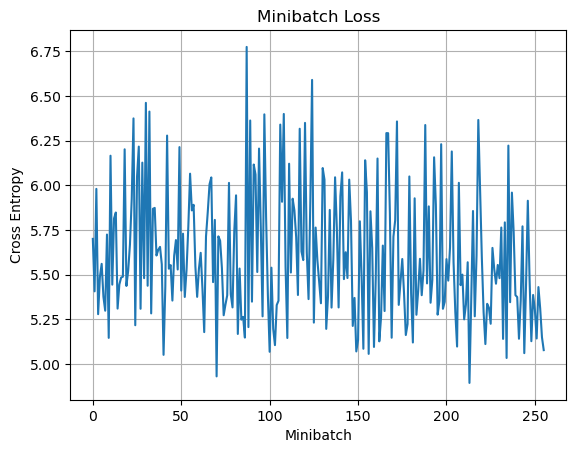

In [ ]:
utils.plot_minibatch_loss(minibatch_loss)

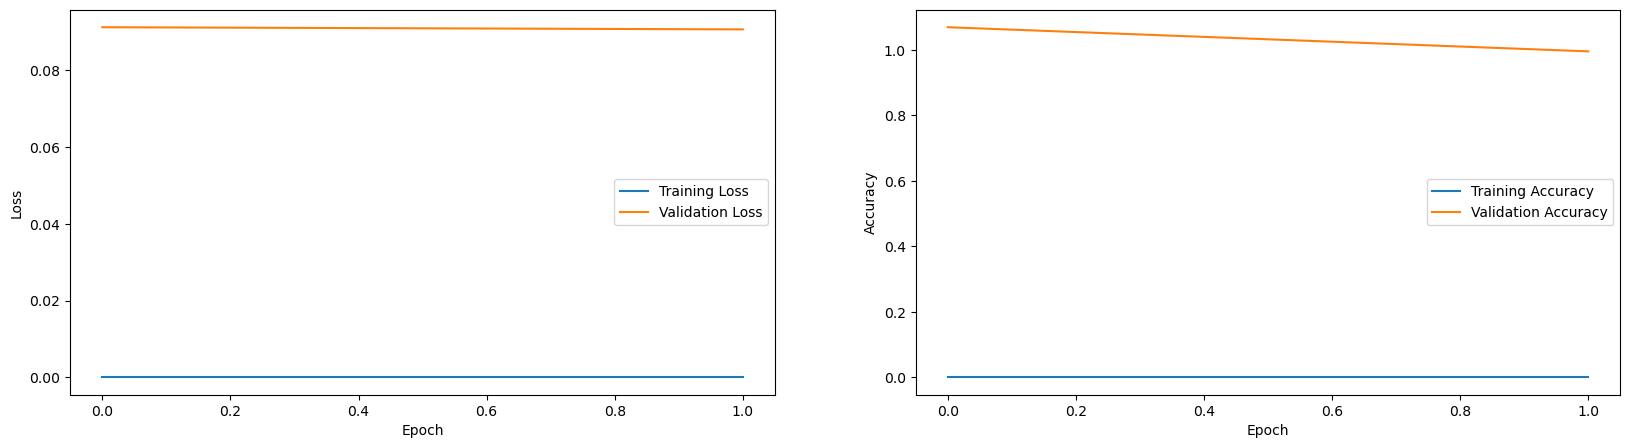

In [ ]:
utils.plot_train_and_valid_loss_and_accuracy(train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst)